Found 4 JSON files
Loaded stats/shard-1.json: 393997 documents
Loaded stats/shard-3.json: 82141826 documents
Loaded stats/shard-2.json: 6419586 documents
Loaded stats/shard-0.json: 24002 documents
Found 3 unique attributes across all files
Attributes: dclm__dclm_oh_eli5__score, dclm__dclm_oh_eli5_log__score, dclm__random_number_v1__random
Creating 1 facet grid plots
Saved plots/facet_grid_1.png


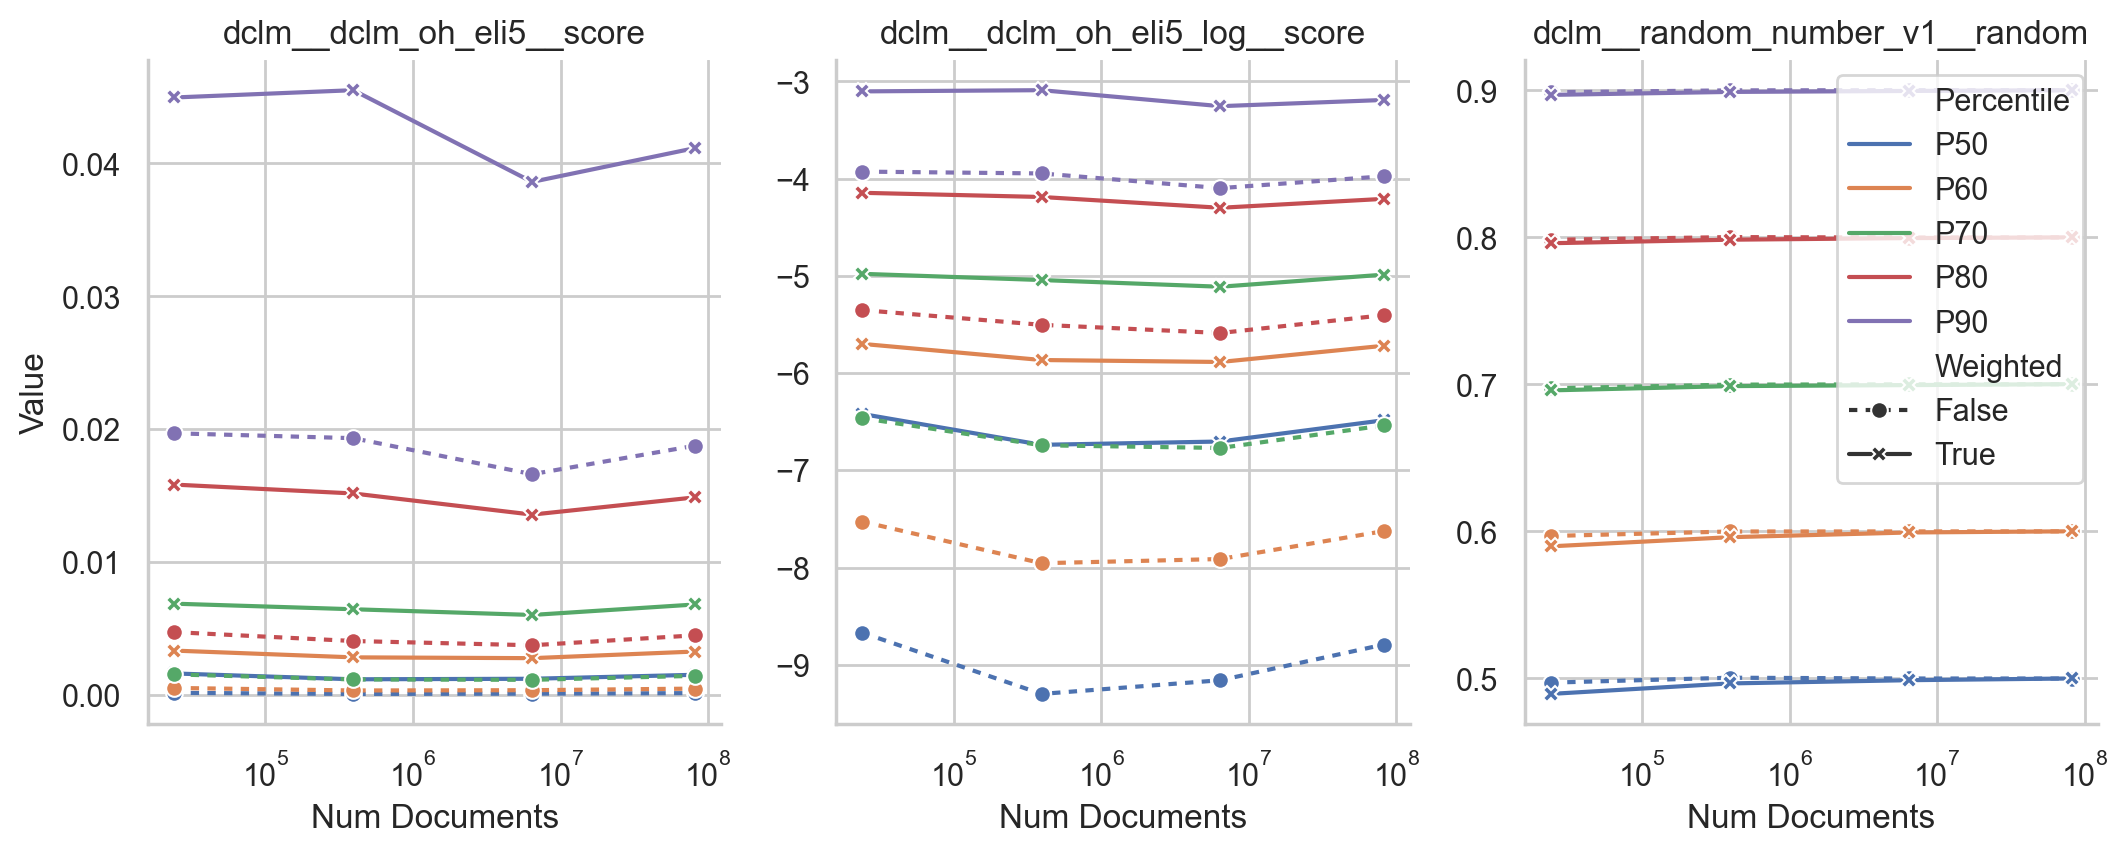

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import json
import glob
import os
import pandas as pd
import seaborn as sns
from typing import Dict, List, Optional, Tuple

def load_stats_files(directory='stats'):
    """Load all JSON files from the specified directory."""
    json_files = glob.glob(f'{directory}/*.json')
    print(f"Found {len(json_files)} JSON files")
    
    # Load data from each JSON file
    data = []
    for json_file in json_files:
        with open(json_file, 'r') as f:
            try:
                stats = json.load(f)
                data.append({
                    'file': json_file,
                    'total_documents': stats['total_documents'],
                    'attributes': stats['attributes']
                })
                print(f"Loaded {json_file}: {stats['total_documents']} documents")
            except Exception as e:
                print(f"Error loading {json_file}: {str(e)}")
    
    # Sort data by total document count
    data.sort(key=lambda x: x['total_documents'])
    return data

def get_all_attributes(data):
    """Extract the list of unique attribute names across all files."""
    all_attributes = set()
    for item in data:
        for attr_name in item['attributes'].keys():
            all_attributes.add(attr_name)
    
    print(f"Found {len(all_attributes)} unique attributes across all files")
    print(f"Attributes: {', '.join(sorted(all_attributes))}")
    return sorted(all_attributes)

def convert_to_combined_dataframe(data, attributes):
    """Convert attributes data to a single pandas DataFrame for facet grid plotting."""
    # Create empty list to store DataFrame rows
    rows = []
    
    # Process each file and attribute
    for item in data:
        doc_count = item['total_documents']
        
        for attribute_name in attributes:
            if attribute_name in item['attributes'] and item['attributes'][attribute_name]['samples'] > 0:
                # Process both weighted and unweighted percentiles
                for type_name in ['weighted', 'unweighted']:
                    percentile_data = item['attributes'][attribute_name][type_name]
                    for percentile, value in percentile_data.items():
                        rows.append({
                            'Num Documents': doc_count,
                            'Attribute': attribute_name,
                            'Percentile': percentile,
                            'Value': value,
                            'Weighted': type_name == 'weighted'
                        })
    
    # Create DataFrame
    return pd.DataFrame(rows)

def plot_attributes_facet_grid(df, output_dir='plots'):
    """Plot attributes using seaborn FacetGrid."""
    if df.empty:
        print("No data to plot")
        return
    
    # Ensure output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Get unique attributes and create a manageable subset if there are too many
    attributes = df['Attribute'].unique()
    
    # Determine grid size based on number of attributes
    # Create multiple grid plots if there are many attributes
    max_attrs_per_grid = 9  # 3x3 grid
    attribute_groups = [attributes[i:i + max_attrs_per_grid] 
                       for i in range(0, len(attributes), max_attrs_per_grid)]
    
    print(f"Creating {len(attribute_groups)} facet grid plots")
    
    for grid_num, attr_group in enumerate(attribute_groups):
        # Filter dataframe for current attribute group
        grid_df = df[df['Attribute'].isin(attr_group)]
        
        # Set up color palette for percentiles
        percentiles = df['Percentile'].unique()
        palette = sns.color_palette("husl", len(percentiles))
        
        #
        # Create facet grid
        g = sns.FacetGrid(
            grid_df, 
            col="Attribute",
            col_wrap=min(3, len(attr_group)),  # 3 columns max
            height=4.5, 
            aspect=0.8,
            sharey=False,
        )
        
        # Map line plots onto the grid
        g.map_dataframe(
            sns.lineplot,
            x="Num Documents",
            y="Value",
            hue="Percentile",
            style="Weighted",
            markers=True,
            dashes=[(2, 2), (None, None)]  # Solid for weighted, dashed for unweighted
        )
        for ax in g.axes.flat:
            ax.set_xscale("log")
        g.set_titles(col_template="{col_name}")
        plt.legend()
        # Adjust layout
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)  # Make room for suptitle
        
        # Save figure
        output_file = f"{output_dir}/facet_grid_{grid_num + 1}.png"
        g.fig.savefig(output_file, dpi=150)
        print(f"Saved {output_file}")
    
    return

def main():
    # Set seaborn style
    sns.set_theme(style="whitegrid")
    
    # Load all JSON files
    data = load_stats_files('stats')
    
    if not data:
        print("No data loaded. Exiting.")
        return
    
    # Get all attributes
    all_attributes = get_all_attributes(data)
    
    # Convert data to combined DataFrame
    df = convert_to_combined_dataframe(data, all_attributes)
    
    # Create and save facet grid plots
    plot_attributes_facet_grid(df)
    
    # Show plots with higher resolution
    plt.rcParams['figure.dpi'] = 200
    plt.show()

if __name__ == "__main__":
    main()
